# Air Quality Index (AQI) Prediction - Google Colab Project Notebook

In [ ]:
# 📌 Phase 1: Setup and Data Loading
!pip install seaborn xgboost plotly
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('city_day.csv')  # Replace with your actual file name
df.head()

Saving city_day.csv.zip to city_day.csv.zip


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
df.ffill(inplace=True)
df.bfill(inplace=True)

print(df.columns)

location_column_name = 'City'
df.drop_duplicates(subset=['Date', location_column_name], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

label_encoder = LabelEncoder()
try:
    df['AQI_Category_Encoded'] = label_encoder.fit_transform(df['AQI_Bucket'])  # Use correct label column
except KeyError:
    print("Column 'AQI_Bucket' not found in the DataFrame. Please check the column name.")

df_with_dummies = pd.get_dummies(df, columns=[location_column_name])

# Drop all non-numeric or unwanted columns before scaling
columns_to_drop = ['AQI', 'AQI_Bucket', 'AQI_Category_Encoded', 'Date']
df_for_scaling = df_with_dummies.drop(columns=columns_to_drop, axis=1, errors='ignore')

scaled_features = MinMaxScaler().fit_transform(df_for_scaling)

X = pd.DataFrame(scaled_features, columns=df_for_scaling.columns)


Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket',
       'AQI_Category_Encoded', 'day', 'month', 'year', 'season'],
      dtype='object')


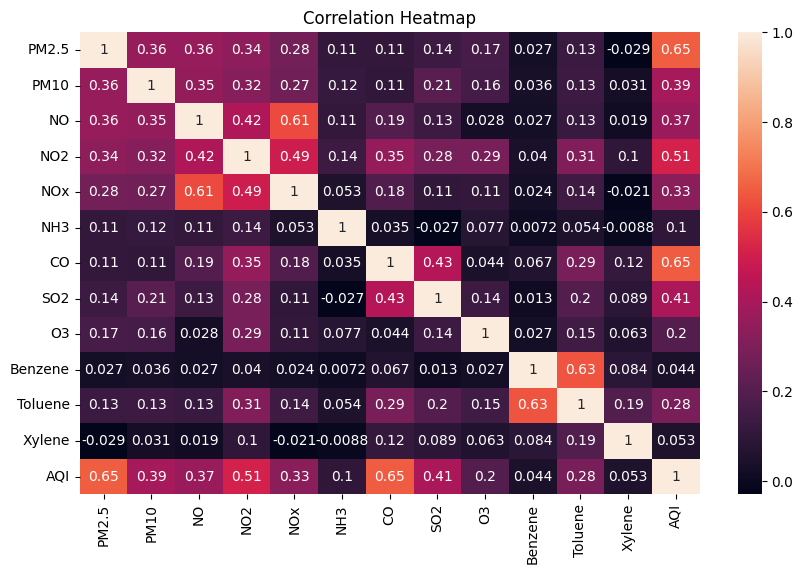

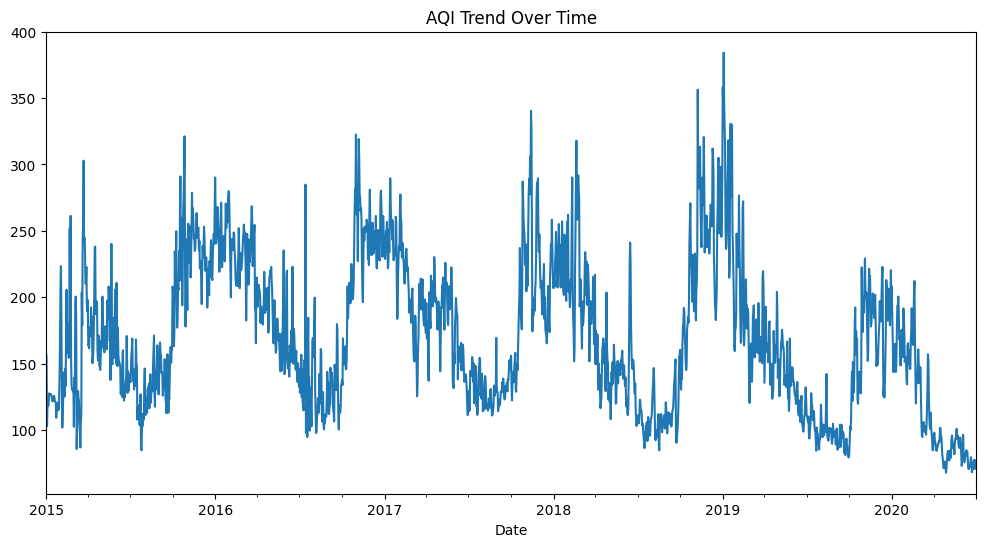

In [ ]:
# 📌 Phase 3: Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
# Select only numerical features for correlation
numerical_df = df.select_dtypes(include=np.number)  # Select numerical columns
sns.heatmap(numerical_df.corr(), annot=True)  # Calculate correlation on numerical data
plt.title('Correlation Heatmap')
plt.show()
plt.figure(figsize=(12, 6))
df.groupby('Date')['AQI'].mean().plot()  # Changed 'timestamp' to 'Date'
plt.title('AQI Trend Over Time')
plt.show()

In [ ]:
# 📌 Phase 4: Feature Engineering
df['day'] = df['Date'].dt.day  # Changed 'timestamp' to 'Date'
df['month'] = df['Date'].dt.month  # Changed 'timestamp' to 'Date'
df['year'] = df['Date'].dt.year  # Changed 'timestamp' to 'Date'
df['season'] = df['month'] % 12 // 3 + 1

In [ ]:
# 📌 Phase 5: Modeling - Regression
# --- Ensure X_reg has the correct columns ---
# Check columns in df: print(df.columns)
# Based on the available columns, select the features for regression
# Adjust the list of columns to drop if 'AQI_Category' is not present
# Assuming your target is 'AQI' and 'AQI_Category' is not present
# If 'AQI_Category' is present, keep it in the list of columns to drop

# Exclude the 'Date' column from the features
# --- Drop 'AQI_Category' along with 'AQI' and 'Date' ---
# X_reg = df.drop(columns=['AQI', 'Date', 'AQI_Category'])  # Dropped 'Date' and 'AQI_Category' columns
# Instead of dropping 'AQI_Category', drop unnecessary columns based on your data
# For example, if you only need numerical features:
#X_reg = df.drop(columns=['AQI', 'Date', 'AQI_Category', 'AQI_Category_Encoded'])  # Dropped 'Date' and 'City' columns. Removed 'AQI_Category'
# Or, list out the specific columns you want to keep:
# Modified to only drop existing columns:
# If 'AQI_Category_Encoded' is present in the DataFrame

# --- Explicitly select numerical features ---
X_reg = df.select_dtypes(include=np.number)  # Select only numerical columns

# --- Drop target and unnecessary columns ---
X_reg = X_reg.drop(columns=['AQI', 'AQI_Category_Encoded', 'day', 'month', 'year', 'season'], errors='ignore') # Dropped 'AQI', 'Date', and 'AQI_Category', 'AQI_Category_Encoded' if exists



#X_reg = df[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'day', 'month', 'year', 'season']]  # Selected specific columns

y_reg = df['AQI']
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred_rf))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R2 Score:', r2_score(y_test, y_pred_rf))

MAE: 19.51535981734534
RMSE: 41.3259287073762
R2 Score: 0.9041882759414485


Saving city_day.csv.zip to city_day.csv (8).zip
Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


<ipython-input-58-e32b9a980a05>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-58-e32b9a980a05>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


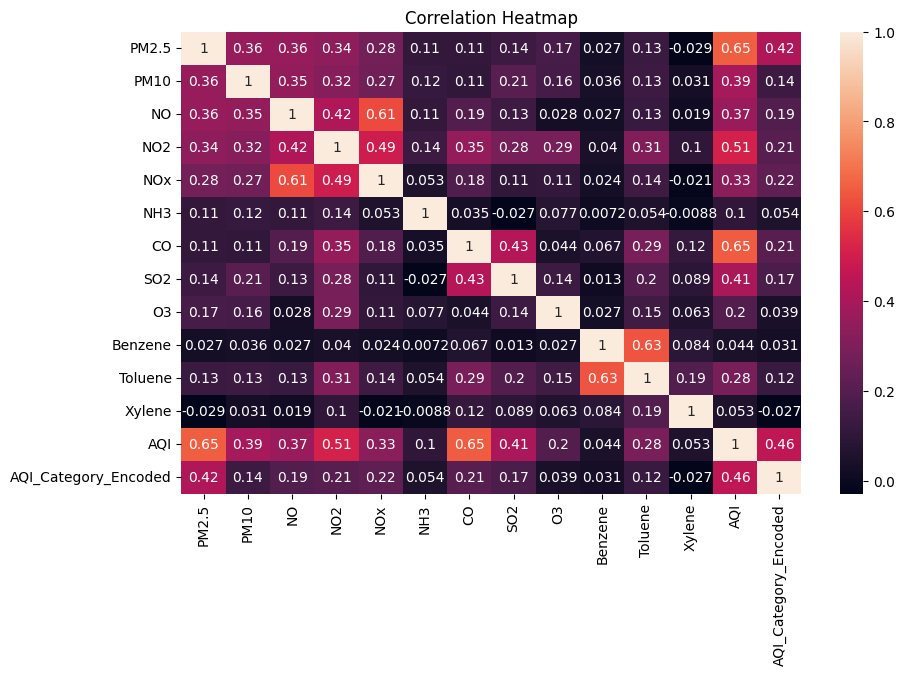

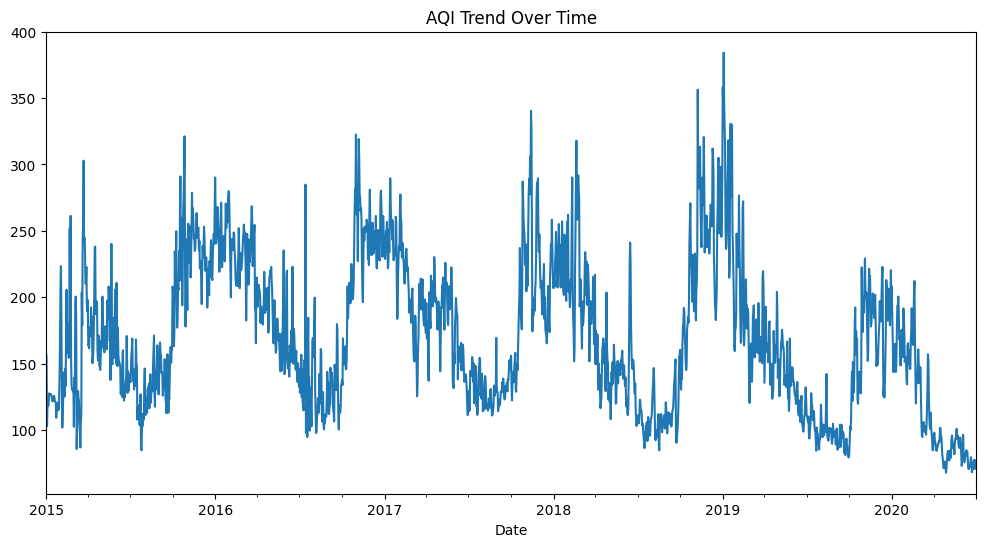

MAE: 19.559059276704147
RMSE: 41.45052293436837
R2 Score: 0.9036096763316994


ValueError: could not convert string to float: 'Very Poor'

In [ ]:
from IPython import get_ipython
from IPython.display import display
!pip install seaborn xgboost plotly
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from google.colab import files

uploaded = files.upload()
df = pd.read_csv('city_day.csv')
df.head()

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
print(df.columns)
location_column_name = 'City'
df.drop_duplicates(subset=['Date', location_column_name], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

label_encoder = LabelEncoder()
try:
    df['AQI_Category_Encoded'] = label_encoder.fit_transform(df['AQI_Bucket'])  # Correct column name
except KeyError:
    print("Column 'AQI_Bucket' not found in the DataFrame. Please check the column name.")


df_with_dummies = pd.get_dummies(df, columns=[location_column_name], dtype=float)  # Specify dtype=float for dummies
scaler = MinMaxScaler()
columns_to_drop = ['AQI', 'Date', 'AQI_Bucket', 'AQI_Category_Encoded']

# errors='ignore' handles the case if a column doesn't exist

# Check if the columns are present before dropping
if 'AQI_Category' in df_with_dummies.columns:
    columns_to_drop.append('AQI_Category')  # Ensure AQI_Category is dropped if it exists
if 'AQI_Category_Encoded' in df_with_dummies.columns:
    columns_to_drop.append('AQI_Category_Encoded')  # Ensure AQI_Category_Encoded is dropped if it exists

scaled_features = scaler.fit_transform(df_with_dummies.drop(columns=columns_to_drop, axis=1, errors='ignore'))
X = pd.DataFrame(scaled_features)

plt.figure(figsize=(10, 6))
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(12, 6))
df.groupby('Date')['AQI'].mean().plot()
plt.title('AQI Trend Over Time')
plt.show()

df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['season'] = df['month'] % 12 // 3 + 1

X_reg = df.select_dtypes(include=np.number)
X_reg = X_reg.drop(columns=['AQI', 'AQI_Category_Encoded', 'day', 'month', 'year', 'season'], errors='ignore')
y_reg = df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred_rf))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R2 Score:', r2_score(y_test, y_pred_rf))

X_c = df_with_dummies.drop(columns=['AQI_Category', 'AQI', 'AQI_Category_Encoded', 'Date'], errors='ignore')
y_c = df['AQI_Bucket']


X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)

print(classification_report(y_test_c, y_pred_c))
sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True)
plt.title('Confusion Matrix')
plt.show()

try:
    feat_imp = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    feat_imp.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Feature Importances')
    plt.show()
except NameError:
    print("Error: model_rf is not defined. Please ensure the model is trained in a previous cell.")


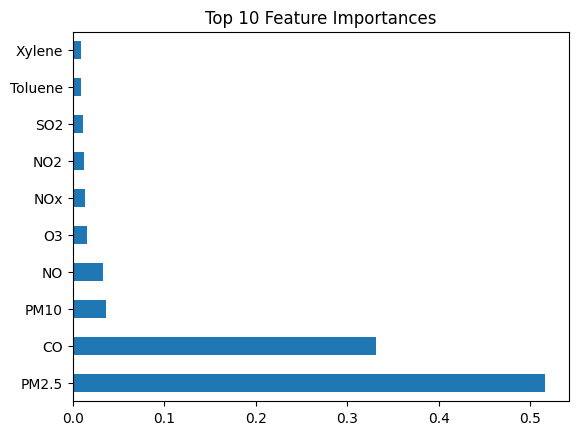

In [ ]:
# 📌 Phase 7: Feature Importance
# Assuming model_rf is defined and trained in a previous cell
# If not, make sure to train the model before this cell
try:
    feat_imp = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    feat_imp.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Feature Importances')
    plt.show()
except NameError:
    print("Error: model_rf is not defined. Please ensure the model is trained in a previous cell.")

In [2]:
!pip install gradio
import gradio as gr
import numpy as np

def predict_aqi(pm25, pm10, no2, so2, co, o3):
    features = np.array([[pm25, pm10, no2, so2, co, o3]])
    prediction = model.predict(features)
    return float(prediction[0])

interface = gr.Interface(
    fn=predict_aqi,
    inputs=[
        gr.Number(label="PM2.5"),
        gr.Number(label="PM10"),
        gr.Number(label="NO2"),
        gr.Number(label="SO2"),
        gr.Number(label="CO"),
        gr.Number(label="O3")
    ],
    outputs="number",
    title="AQI Prediction",
    description="Enter pollutant values to predict the Air Quality Index (AQI)"
)

interface.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c6a37c0b41e97d3cf7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory 